<a href="https://colab.research.google.com/github/yuvalpn/ev_cars_data/blob/main/EV_CARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
import pandas as pd
import os

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/my_data/cars_data_RAW.csv'

if os.path.exists(file_path):
    print("הקובץ נמצא! טוען נתונים...")
    df = pd.read_csv(file_path)
    # הצגת 5 השורות הראשונות לבדיקה
    display(df.head())
else:
    print(f"שגיאה: הקובץ לא נמצא בנתיב: {file_path}")
    print("אנא וודא שהתיקייה 'my_data' קיימת ב-'My Drive' הראשי שלך ושם הקובץ מדוייק.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
הקובץ נמצא! טוען נתונים...


,Row_ID,title,model,battery,price-range,0 - 100,Top Speed,Range*,Efficiency*,Fastcharge*,Germany_price_before_incentives,Netherlands_price_before_incentives,UK_price_after_incentives,Drive_Configuration,Tow_Hitch,Towing_capacity_in_kg,Number_of_seats
0,1,Tesla,Model 3,57.5,104,6.1 sec,201 km/h,415 km,139 Wh/km,690 km/h,"€41,970","€41,990","£39,990",Rear Wheel Drive,Towbar possible,1000.0,5
1,2,Tesla,Model Y,57.5,137,6.9 sec,217 km/h,350 km,164 Wh/km,580 km/h,"€45,970","€45,990","£44,990",Rear Wheel Drive,Towbar possible,1600.0,5
2,3,Tesla,Model Y Long Range Dual Motor,75.0,130,5.0 sec,217 km/h,435 km,172 Wh/km,670 km/h,"€55,970","€52,990","£52,990",All Wheel Drive,Towbar possible,1600.0,5
3,4,Tesla,Model 3 Long Range Dual Motor,75.0,106,4.4 sec,201 km/h,500 km,150 Wh/km,770 km/h,"€50,970","€49,990","£49,990",All Wheel Drive,Towbar possible,1000.0,5
4,5,Tesla,Model Y Long Range RWD,75.0,109,5.9 sec,217 km/h,460 km,163 Wh/km,710 km/h,"€49,970","€49,990",NaN,Rear Wheel Drive,Towbar possible,1600.0,5


In [18]:
# 1. הגדרת רשימת העמודות שאנחנו רוצים לשמור (זה החלק שהיה חסר או לא הוגדר)
cols_to_keep = [
    'title', 'model', 'battery_kwh', 'range_km', 'efficiency_whkm',
    'fastcharge_kmh', 'top_speed_kmh', 'accel_sec',
    'price_de', 'price_nl', 'price_uk',
    'Drive_Configuration', 'towing_capacity_kg', 'seats'
]

# 2. יצירת הטבלה הסופית עם העמודות שבחרנו בלבד
final_df = df_clean[cols_to_keep]

# 3. יצירת חיבור למסד נתונים וטעינה
conn = sqlite3.connect('ev_cars.db')
final_df.to_sql('cars', conn, if_exists='replace', index=False)
conn.close()

print("הנתונים נשמרו בהצלחה!")
display(final_df.head())

הנתונים נשמרו בהצלחה!


,title,model,battery_kwh,range_km,efficiency_whkm,fastcharge_kmh,top_speed_kmh,accel_sec,price_de,price_nl,price_uk,Drive_Configuration,towing_capacity_kg,seats
0,Tesla,Model 3,57.5,415.0,139.0,690.0,201.0,6.1,41970.0,41990.0,39990.0,Rear Wheel Drive,1000.0,5
1,Tesla,Model Y,57.5,350.0,164.0,580.0,217.0,6.9,45970.0,45990.0,44990.0,Rear Wheel Drive,1600.0,5
2,Tesla,Model Y Long Range Dual Motor,75.0,435.0,172.0,670.0,217.0,5.0,55970.0,52990.0,52990.0,All Wheel Drive,1600.0,5
3,Tesla,Model 3 Long Range Dual Motor,75.0,500.0,150.0,770.0,201.0,4.4,50970.0,49990.0,49990.0,All Wheel Drive,1000.0,5
4,Tesla,Model Y Long Range RWD,75.0,460.0,163.0,710.0,217.0,5.9,49970.0,49990.0,NaN,Rear Wheel Drive,1600.0,5


In [19]:
import sqlite3
import pandas as pd

# יצירת חיבור למסד הנתונים
conn = sqlite3.connect('ev_cars.db')

# --- שאילתה 1: מי נותן הכי הרבה תמורה לכסף? (טווח נסיעה לכל אירו) ---
# אנחנו מחלקים את הטווח במחיר (בגרמניה) כדי לקבל "ק"מ לכל אירו"
query1 = """
SELECT
    title,
    model,
    range_km,
    price_de,
    ROUND(range_km / price_de * 1000, 2) AS meters_per_euro
FROM cars
WHERE price_de IS NOT NULL
ORDER BY meters_per_euro DESC
LIMIT 10;
"""

print("--- Top 10: Value for Money (Meters per Euro) ---")
display(pd.read_sql(query1, conn))


# --- שאילתה 2: דירוג יצרנים לפי ביצועים ממוצעים ---
# נרצה לראות איזה יצרן מוביל בטווח, ומי הכי יקר בממוצע
query2 = """
SELECT
    title AS Brand,
    COUNT(*) AS models_count,
    ROUND(AVG(range_km), 0) AS avg_range_km,
    ROUND(AVG(price_de), 0) AS avg_price_euro,
    ROUND(AVG(fastcharge_kmh), 0) AS avg_fastcharge
FROM cars
GROUP BY title
HAVING models_count >= 2 -- סינון יצרנים עם דגם אחד בלבד כדי למנוע הטיה
ORDER BY avg_range_km DESC;
"""

print("\n--- Manufacturer Leaderboard (Avg Specs) ---")
display(pd.read_sql(query2, conn))

# סגירת החיבור
conn.close()

--- Top 10: Value for Money (Meters per Euro) ---


,title,model,range_km,price_de,meters_per_euro
0,Citroen,e-C3,265.0,23300.0,11.37
1,Byd,SEAL 82.5 kWh RWD Design,500.0,44990.0,11.11
2,Renault,5 E-Tech 40kWh 95hp,260.0,25000.0,10.40
3,Byd,DOLPHIN 60.4 kWh,340.0,32990.0,10.31
4,Renault,5 E-Tech 52kWh 150hp,330.0,32000.0,10.31
5,Renault,Scenic E-Tech EV87 220hp,490.0,48900.0,10.02
6,Xpeng,P7 RWD Long Range,495.0,49600.0,9.98
7,Tesla,Model 3,415.0,41970.0,9.89
8,Tesla,Model 3 Long Range Dual Motor,500.0,50970.0,9.81
9,Xpeng,G6 RWD Long Range,490.0,50000.0,9.80



--- Manufacturer Leaderboard (Avg Specs) ---


,Brand,models_count,avg_range_km,avg_price_euro,avg_fastcharge
0,Lucid,3,603.0,104333.0,917.0
1,Lotus,6,493.0,125885.0,1090.0
2,Porsche,20,490.0,149755.0,1069.0
3,Polestar,8,462.0,64935.0,634.0
4,Vinfast,3,457.0,67223.0,540.0
5,Xpeng,9,455.0,57956.0,888.0
6,Tesla,12,454.0,69455.0,703.0
7,Fisker,3,450.0,55463.0,553.0
8,Zeekr,5,444.0,58070.0,644.0
9,Audi,14,444.0,73289.0,667.0


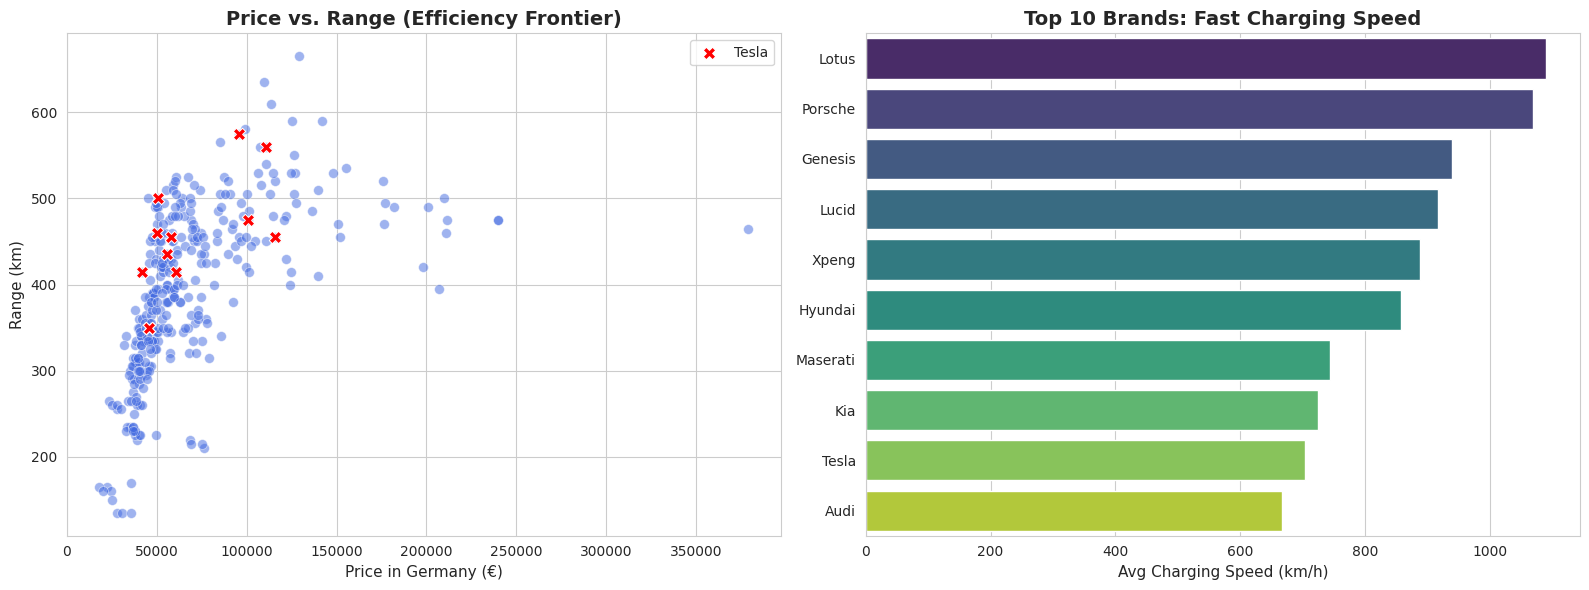

In [20]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. פתיחת החיבור מחדש (חובה כי הוא נסגר בתאים קודמים)
conn = sqlite3.connect('ev_cars.db')

# 2. שליפת הנתונים לגרף הראשון
query_all = """
SELECT title, model, price_de, range_km
FROM cars
WHERE price_de IS NOT NULL AND range_km IS NOT NULL
"""
df_plot = pd.read_sql(query_all, conn)

# 3. שליפת הנתונים לגרף השני
query_fast = """
SELECT title, AVG(fastcharge_kmh) as avg_charge
FROM cars
GROUP BY title
HAVING COUNT(*) > 1
ORDER BY avg_charge DESC
LIMIT 10
"""
df_fast = pd.read_sql(query_fast, conn)

# 4. ציור הגרפים
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# גרף ימין
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot, x='price_de', y='range_km', alpha=0.5, color='royalblue', s=50)
tesla_data = df_plot[df_plot['title'].str.contains('Tesla', case=False)]
sns.scatterplot(data=tesla_data, x='price_de', y='range_km', color='red', s=80, label='Tesla', marker='X')
plt.title('Price vs. Range (Efficiency Frontier)', fontsize=14, fontweight='bold')
plt.xlabel('Price in Germany (€)', fontsize=11)
plt.ylabel('Range (km)', fontsize=11)
plt.legend()

# גרף שמאל
plt.subplot(1, 2, 2)
sns.barplot(data=df_fast, x='avg_charge', y='title', palette='viridis', hue='title', legend=False)
plt.title('Top 10 Brands: Fast Charging Speed', fontsize=14, fontweight='bold')
plt.xlabel('Avg Charging Speed (km/h)', fontsize=11)
plt.ylabel('')

plt.tight_layout()
plt.show()

# 5. סגירת החיבור בסוף
conn.close()